<a href="https://colab.research.google.com/github/tomfox1/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

In [1]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.5MB/s 


#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

In [3]:
#inspecting data 
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [23]:
#will have to deal with NaNs
train.isna().sum().sort_values()

Inspection ID         0
Inspection Date       0
Address               0
Fail                  0
DBA Name              0
Inspection Type       1
License #             5
State                10
Risk                 12
Zip                  26
City                 53
Location            198
Latitude            198
Longitude           198
Facility Type       224
AKA Name            623
Violations         9655
dtype: int64

In [5]:
#high cardinality as expected for: "DBA Name", "AKA Name", "Address", "Inspection Date", "Location", "Violations"
train.describe(include='all')

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
count,5.191600e+04,51916,51293,5.191100e+04,51692,51904,51916,51863,51906,51890.000000,51916,51915,42261,51718.000000,51718.000000,51718,51916.000000
unique,NaN,17049,16350,NaN,329,3,13954,39,1,NaN,2257,51,42164,NaN,NaN,13410,NaN
top,NaN,SUBWAY,SUBWAY,NaN,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,NaN,2017-03-23T00:00:00,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,NaN,NaN,"{'longitude': '-87.91442843927047', 'latitude'...",NaN
freq,NaN,654,802,NaN,34264,37731,741,51659,51906,NaN,50,24170,3,NaN,NaN,741,NaN
mean,1.330265e+06,NaN,NaN,1.549491e+06,NaN,NaN,NaN,NaN,NaN,60628.834669,NaN,NaN,NaN,41.879568,-87.676663,NaN,0.258610
std,6.202664e+05,NaN,NaN,9.018283e+05,NaN,NaN,NaN,NaN,NaN,22.736963,NaN,NaN,NaN,0.081126,0.059509,NaN,0.437875
min,4.425000e+04,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,60007.000000,NaN,NaN,NaN,41.644670,-87.914428,NaN,0.000000
25%,6.796205e+05,NaN,NaN,1.140745e+06,NaN,NaN,NaN,NaN,NaN,60614.000000,NaN,NaN,NaN,41.830296,-87.707857,NaN,0.000000
50%,1.424226e+06,NaN,NaN,1.958619e+06,NaN,NaN,NaN,NaN,NaN,60625.000000,NaN,NaN,NaN,41.890166,-87.666524,NaN,0.000000
75%,1.946952e+06,NaN,NaN,2.215507e+06,NaN,NaN,NaN,NaN,NaN,60643.000000,NaN,NaN,NaN,41.939167,-87.634461,NaN,1.000000


In [6]:
#baseline model ~74% accuracy if majority class "0:Inspection Passed" is predicted 100% of the time 
#How do we know our intuition is correct, 74% seems to be a high score right? 
#if our majority class were ~ 25% there wouldn't be any restaurants in Chicago
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [0]:
#some imports for preprocessing and model fit 
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from random import randint

In [8]:
#WOW: did you type all these out? Nope: used X.columns.to_list()'
#our train/test data has already been subdivided for us, thanks Mr.Herr
features = ['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Violations',
 'Latitude',
 'Longitude',
 'Location']

target = ['Fail']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((51916, 16), (51916, 1), (17306, 16), (17306, 1))

In [25]:
#will preprocess with ordinal encoder to handle categoricals and simple imputer to handle NaNs
#our column headers are numbers now, good thing our ML model gives no **** !!!
encoder = OrdinalEncoder()
imputer = SimpleImputer()

X_train = encoder.fit_transform(X_train)

X_train = imputer.fit_transform(X_train)
pd.DataFrame(X_train).head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2088270.0,1.0,1.0,2354911.0,1.0,1.0,1.0,1.0,1.0,60657.0,1.0,1.0,41.938007,-87.644755,1.0
1,555268.0,2.0,2.0,1044901.0,2.0,2.0,2.0,1.0,1.0,60636.0,2.0,2.0,41.772402,-87.683603,2.0
2,1751394.0,3.0,3.0,47405.0,1.0,1.0,3.0,1.0,1.0,60649.0,3.0,3.0,41.758779,-87.575054,3.0
3,1763905.0,4.0,4.0,6414.0,1.0,3.0,4.0,1.0,1.0,60632.0,4.0,4.0,41.812181,-87.707125,4.0
4,453326.0,5.0,5.0,24571.0,3.0,1.0,5.0,1.0,1.0,60629.0,5.0,5.0,41.879568,-87.676663,5.0


In [10]:
#fitting out XGBoost Classifier 
#XGBoost fits sequentially, and works well with "stumps"
#increasing 'Max Depth' would make it MEGA slow and not increase cross-val scores that much 
#almost 1 min to fit, yikes 
param_distributions = {
    'n_estimators': [100, 200, 300] ,
    'max_depth': [1, 2]
}

search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   55.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300], 'max_depth': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [11]:
#interesting, however, we'll need to wait and check out scores on the test data 
print("ROC AUC cross validations scores:", search.best_score_)

ROC AUC cross validations scores: 0.7036329308225295


In [0]:
#preprocessing test variable
best = search.best_estimator_
X_test = encoder.fit_transform(X_test)
X_test = imputer.fit_transform(X_test)


In [13]:
#calculating probabilities for majority class in order to compute cross-val scores 
y_pred_proba = best.predict_proba(X_test)[:, 1]
pd.DataFrame(y_pred_proba).head()

,0
0,0.095235
1,0.067509
2,0.124178
3,0.016523
4,0.112178


In [14]:
#ROC AUC score > 65% for our test score, not that great as compared to our 75% score for baseline model 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba)

0.6599324088091472

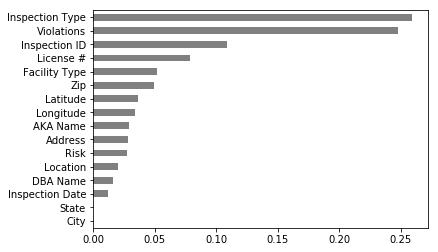

In [15]:
#plotting feature importances for our XGBoost model best estimator's found with parameter optimization using RandomSearchCV
#gray is a dull color perhaps but my model is rocking it so will leave it be 
a = train.drop(columns='Fail')

X_test = pd.DataFrame(X_test)

pd.Series(search.best_estimator_.feature_importances_, a.columns).sort_values().plot.barh(color='grey');

**ANSWER 1)**

Gradient Descent seeks to minimize a cost function by calculating the derivative of a differentiable function 
at an initial  random point and subsequently multiplying (and iterating it) by the negative gradient at that point until we've reach the global/local minima. Note: we multiply the learning rate by the negative gradient because we want our point to tend to 0, i.e., in the opposite direction of our derivative function at that point.

**ANSWER 2)**

The learning rate, or alpha, is a positive number used to multiply the negative gradient value ; choosing an appropriate learning rate is important as high numbers can lead to divergence or overshooting of our hypothesis, while very small numbers will make it impossible to reach our minima through an appropriate number of  "steps".

In [16]:
#extra analysis 

!pip install eli5
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 57.7MB 1.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 225kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [17]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [39]:
#'Inspection Type' is by far the most important feature, removing it would decrease the accuracy score of our model by ~ 13%
feature_names = a.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1367 ± 0.0068,Inspection Type
0.0123 ± 0.0003,License #
0.0067 ± 0.0009,Zip
0.0056 ± 0.0017,Longitude
0.0038 ± 0.0009,Facility Type
0.0026 ± 0.0002,Latitude
0.0010 ± 0.0001,Risk
0.0008 ± 0.0011,Location
0.0002 ± 0.0000,Inspection Date
0 ± 0.0000,State


In [19]:
#preprocessing to fit our XGBoost Regressor without "Inspection Type"
features = ['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Violations',
 'Latitude',
 'Longitude',
 'Location']

target = ['Fail']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((51916, 15), (51916, 1), (17306, 15), (17306, 1))

In [20]:
encoder = OrdinalEncoder()
imputer = SimpleImputer()

X_train = encoder.fit_transform(X_train)

X_train = imputer.fit_transform(X_train)
pd.DataFrame(X_train).head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2088270.0,1.0,1.0,2354911.0,1.0,1.0,1.0,1.0,1.0,60657.0,1.0,1.0,41.938007,-87.644755,1.0
1,555268.0,2.0,2.0,1044901.0,2.0,2.0,2.0,1.0,1.0,60636.0,2.0,2.0,41.772402,-87.683603,2.0
2,1751394.0,3.0,3.0,47405.0,1.0,1.0,3.0,1.0,1.0,60649.0,3.0,3.0,41.758779,-87.575054,3.0
3,1763905.0,4.0,4.0,6414.0,1.0,3.0,4.0,1.0,1.0,60632.0,4.0,4.0,41.812181,-87.707125,4.0
4,453326.0,5.0,5.0,24571.0,3.0,1.0,5.0,1.0,1.0,60629.0,5.0,5.0,41.879568,-87.676663,5.0


In [21]:
#fitting out XGBoost Classifier without "Inspection Type"
param_distributions = {
    'n_estimators': [100, 200, 300] ,
    'max_depth': [1, 2]
}

search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   52.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300], 'max_depth': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [40]:
#our ROC AUC cross-val score falls by ~ 13% as our permutation importance would suggest 
print("ROC AUC cross validations scores:", search.best_score_)

ROC AUC cross validations scores: 0.624802580785887
